# Машинное обучение для текстов

Новый сервис интернет-магазина позволяет пользователям редактировать и дополнять описания товаров, как в вики-сообществах - клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать недопустимые к публикации комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Данные находятся в файле `toxic_comments.csv`. Столбец **text** в нём содержит текст комментария, а **toxic** — целевой признак.

## Подготовка библиотек

In [1]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [2]:
# загрузка пакетов библиотеки лемматизации WordNetLemmatizer и списка "стоп" слов
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# создание списка "стоп" слов английского языка
stop_words = set(stopwords.words('english')) 

In [5]:
# создание объектов классов предобработки текстов
count_vect = CountVectorizer(stop_words=stop_words)
count_tf_idf = TfidfVectorizer()
lemmatizer = WordNetLemmatizer()

## Загрузка и знакомство с данными

In [6]:
# загрузка данных
data = pd.read_csv('/datasets/toxic_comments.csv')

In [7]:
# несколько случайно выбранных записей позволяют визуально оценить датасет
data.sample(6)

,text,toxic
14298,"If you think this was a little story, I can on...",0
75353,Hi Ged and Elen. I was pointed to the statemen...,0
81709,"""\n\nDYK\nOn 28 August, 2007, Did you know? wa...",0
141039,"Welcome!\n\nHello , and welcome to Wikipedia! ...",0
145899,"""\n\nRead the """"Signing"""" section of the artic...",0
143796,"list of surgeons \n Recently, the list of surg...",0


In [8]:
# оценим размеры датасета, тип данных записей
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
# записи уникальны
data.duplicated().sum()

0

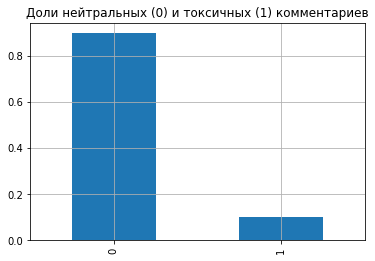

In [10]:
# посмотрим на соотношение значений целевого признака
data['toxic'].value_counts(normalize=True).plot(kind='bar', 
                                                grid=True, 
                                                title='Доли нейтральных (0) и токсичных (1) комментариев');

### Выводы

В состав датасета входят почти 160 тыс. записей пользоателей на английском языке. Пропусков и дубликатов нет. Данные для целевого признака ['toxic'] несбалансированны - соотношение 9:1, что следует учесть при разбиении на обучающую и тестовую выборку. На следующем этапе предстоит выполнить векторизацию текста для извлечения признаков.

## Предобработка

Напишем функцию preprocess() которая последовательно:
- С помощью регулярных выражений уберет из текста спецсимволы, пробелы и т.д.
- Разобьет на токены текст
- Выполнит лемматизацию списков слов

В свою очередь функция preprocess() использует функцию get_pos(), которая для каждого слова извлекает тэг, указывающий на часть речи, к которой относится рассматриваемое слово. Более тщательное приведение слов к их леммам позволит уменьшить размеры датасета.

In [11]:
# функция определения части речи для слова
## принимает на вход слово
def get_pos(word):
    # с помощьювстроенного в nltk метода извлекает трехбуквенный тэг части речи
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # каждому значению сопоставляется тэг в кодировке понятной лемматизатору
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)   

In [12]:
# функция предобработки текстов вариант 1
def preprocess(text):
    # из текста каждой записи извлекаются только буквы, указанные в шаблоне, убираются лишние пробелы и др.символы
    cleared = ' '.join(re.sub(r'[^A-Za-z ]', ' ', text).lower().split())
    # текст каждой записи преобразуется в список слов
    tokenized = nltk.word_tokenize(cleared)
    # каждое слово лемматизируется
    lemmatized = [lemmatizer.lemmatize(x, get_pos(x)) for x in tokenized]
    # текст, прошдший обработку занимает место старого текста
    text = ' '.join(str(x) for x in lemmatized)
    return text

In [13]:
# функция предобработки текстов вариант 2
def process_text(s):
    s = s.lower()
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in word_tokenize(s) if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words if word != ""]
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

Использование функции подстановки тэга для части речи, совместно с lower() уменьшило размеры матрицы векторного представления текстов более чем на 10%. Однако время обработки (лемматизации) увеличивается на порядок. В условиях реальной (неисследовательской) задачи этот факт может стать причиной для выбора разных стратегий поведения: например, провести максимально качественную предобработку текста затратив ресурсы, но отдать моделям более компактный датасет, что повысит качество предсказаний. Или делать быструю предобработку и ориентироваться пусть на не лучшее, но приемлемое качество предсказания.

In [14]:
%%time
# поместим лемматизированный текст в новый столбец 
data['lemm_text'] = data['text'].apply(lambda x: process_text(x)).values

CPU times: user 2min 12s, sys: 244 ms, total: 2min 12s
Wall time: 2min 12s


In [15]:
# так выглядит текст после предобработки
data['lemm_text'][0]

'explanation edits made username hardcore metallica fan reverted nt vandalism closure gas voted new york doll fac please nt remove template talk page since retired'

In [16]:
# этот же текст до предобработки 
data['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Слово 'edits' , например, не приведено к единственному числу. Остаток от отрицания nt не был опознан в качестве стоп слова. Список стоп слов можно кастомизировать под более специфичные задачи добавляя свои исключения.

In [17]:
# проверим есть ли 'nt' в списке стоп слов
'nt' in stop_words

False

## Разбиение на обучающую и тестировочную выборки

На данном этапе разделим данные на обучающую и тестовую выборки. После чего можно будет переходить к векторизации.

In [18]:
# целевой и обучающий признаки
feature = data['lemm_text']
target =data['toxic']

In [19]:
# при разбиении на обучающую и тестовую выборки укажем алгоритму, что данные в target несбалансированны
feature_train, feature_test, target_train, target_test = train_test_split(feature, target, 
                                                                          test_size=0.33, 
                                                                          random_state=42, 
                                                                          stratify=target)

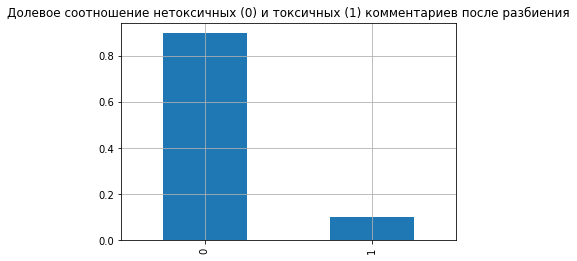

In [20]:
# посмотрим сохранилось ли соотношение значений целевого признака после разбиения на обучающую и тестовую выборки
target_test.value_counts(normalize=True).plot(kind='bar', 
                                                grid=True, 
                                                title='Долевое соотношение нетоксичных (0) и токсичных (1) комментариев после разбиения');

## Векторизация

Объект count_tf_idf класса TfidfVectorizer со списком стоп слов мы уже создали выше. Посчитаем веса уникальных слов и создадим матрицу их значимости.

In [21]:
# преобразуем лемматизированные ранее текст в векторное представление
tf_idf = count_tf_idf.fit_transform(feature_train) 

In [22]:
# размеры матицы векторного представления
tf_idf.shape

(106912, 150600)

In [23]:
# убедимся что количество строк созданной матрицы совпадает с количеством строк
## соответствующей ей матрицы целевого признака
target_train.shape

(106912,)

In [24]:
# обучающим признаком будет являться полученная матрица векторов значимости слов
feature_train = tf_idf

In [25]:
# признаками для тестирования будут вектора, полученные с помощью обученного на 
## обучающей выборке объекта count_tf_idf
### с помощью него преобразуем признаки для тестирования моделей
feature_test = count_tf_idf.transform(feature_test)

Теперь мы имеем все, чтобы начать обучение моделей

## Обучение и тестирование моделей

### LogisticRegression

С помощью GridSearchCV подберем параметры для логистической регресии. Время выполнения - 42 мин. Результат: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

In [26]:
# сообщим модели, что классы несбалансированны и увеличим количество итераций до 500
model = LogisticRegression(class_weight='balanced', max_iter=500)

In [27]:
# создадим словарь гиперпараметров для перебора
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [28]:
# передадим словарь гиперпараметров конструктору
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='f1',error_score=0)

In [29]:
%%time
# полученные параметры поместим в переменную params
grid_result = grid_search.fit(feature_train, target_train)
params = grid_result.best_params_

In [30]:
# полученные параметры для логистической регрессии
params = {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

In [31]:
# инициируем модель логистической регрессии с оптимальными параметрами
clf = LogisticRegression(class_weight='balanced', max_iter=500, **params, random_state=234)

In [32]:
%%time
# обучение логистической регресии
clf.fit(feature_train, target_train)

CPU times: user 57.7 s, sys: 1min 11s, total: 2min 9s
Wall time: 2min 9s


LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                   random_state=234)

In [33]:
# предсказания логистической регресии
predict = clf.predict(feature_test)

In [34]:
# оценка качества предсказаний логистической регрессии метрика F1
f1_lr = f1_score(target_test, predict)
f1_lr

0.7615237432596973

### DecisionTreeClassifier

По аналогичной схеме подберем параметры для дерева решений. Время выполнения 40 мин. Найденные параметры: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}

In [35]:
# создадим словарь гиперпараметров
params_dt = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [36]:
# сообщим создаваемой модели о несбалансированности классов
dt = DecisionTreeClassifier(class_weight='balanced', random_state=888)

In [37]:
# передадим конструктору список параметров для оценки
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params_dt, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [38]:
%%time
# приступим к поиску оптимальных настроек модели перебирая различные варианты на наших данных
grid_result_dt = grid_search.fit(feature_train, target_train)

In [39]:
# найдены оптимальные параметры
best_params = grid_result_dt.best_params_

In [40]:
# поместим найденные параметры в переменнную best_params явно, чтобы не запускать процесс их подбора
best_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}

In [41]:
# инициализируем модель с оптимальными настройками
dt = DecisionTreeClassifier(class_weight='balanced', **best_params, random_state=888)

In [42]:
%%time
# обучим
dt.fit(feature_train, target_train)

CPU times: user 13.2 s, sys: 19 ms, total: 13.3 s
Wall time: 13.3 s


DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, random_state=888)

In [43]:
# получим предсказания на тестовой выборке
predict_dt = dt.predict(feature_test)

In [44]:
# подсчитаем метрику F1
f1_dt = f1_score(target_test, predict_dt)
f1_dt

0.6013464526152252

### CatBoostClassifier

Передадим модели минимальный набор настроек, потому что CatBoost показывает хорошие результаты "из коробки". Сообщим только как распределить веса нулей и единиц в целевом признаке. Модель обучается 33 минуты. F1 = 0.75

In [45]:
# инициализируем классификатор CatBoost 
model = CatBoostClassifier(class_weights=[0.1, 0.9], random_state=42)

In [46]:
%%time
# обучим модель
model.fit(feature_train, target_train)

In [47]:
# получим предскзания CatBoost
predict_cb = model.predict(feature_test)

In [48]:
# метрика f1 для СatBoost
f1_cb = f1_score(target_test, predict_cb)
f1_cb

## Выводы

Модель логистической регрессии без оптимизации гиперпараметров выдавала результат 0,74. На этот результат невозможно было повлиять качеством предобработки. После оптимизации модели значение метрики F1 составило 0,76.
Для DecisionTreeClassifier максимальное значение метрики F1 составило 0,6.
CatBoostClassifier с настройками по умолчанию показал требуемое значение метрики.
Просто наблюдения по ходу проекта:
- Вроде бы качество предобработки должно влиять на качество работы модели. Но, после проставленных тегов частей речи в лемматизаторе обработка затянулась почти на 20 мин, вместо 2 мин. Вектор стал короче на 10%, а метрика осталась неизменной.
- На метрику влияют пропорции выборок test и train. Выглядит странным, что при разбиении 1:9, метрика ухудшается по сравнению с разбиением 0.33:0.66. Ведь мы отдаем больше слов на обучение.
- Даже с автоматическим подбором параметров, метрика едва преодолела требуемое значение. Значит ли это, что 0.75 является нормой для таких исследований. Интересно было бы узнать каковы сейчас отраслевые стандарты распознавания текста и что еще может быть источником повышения качества распознавания.